## Example notebook for downsampling data with `ROMspline`

In [1]:
# Import necessary modules
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

import romSpline

In [2]:
# Make up some test data to show how to use the code.
x = np.linspace(-1, 1, 100001)

def f(x):
    return np.sin(5.*(x-0.2)**2) + np.exp(-(x-0.5)**2/2./0.01)*np.sin(100*x)

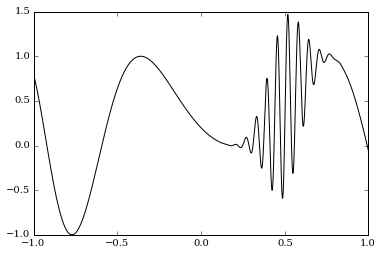

In [3]:
# Plot the test data to see how it looks.
plt.plot(x, f(x), 'k-');

In [4]:
# Create a reduced-order spline by making an instance of the ReducedOrderSpline class.
spline = romSpline.ReducedOrderSpline(x, f(x), verbose=True)

# Because data, namely, x and f(x), are given then the class goes ahead and builds the
# reduced-order spline via a greedy algorithm. In this example, 215 points are needed 
# to represent the 100001 original data samples to within an error of 1e-6 for a 
# compression factor of 100001/215 = 465.

# Additional options include:
#     deg -- degree of interpolating spline polynomials (default is 5)
#     tol -- tolerance of greedy algorithm (default is 1e-6)


Size 	Error
1 	1.22681463893
2 	1.94032421067
3 	23.9875228757
4 	11.4227837826
5 	7.24966570652
6 	4.94063201479
7 	6.62318039675
8 	3.47822853317
9 	3.23179046831
10 	2.91065695417
11 	4.0093536272
12 	4.73780505513
13 	3.39580651026
14 	3.12988074173
15 	2.98345859093
16 	2.9341194734
17 	2.21356875169
18 	2.14240845009
19 	2.72162311549
20 	2.10232346473
21 	1.60670368013
22 	1.39598050225
23 	0.665854641937
24 	0.520027169275
25 	0.402887098392
26 	0.304649860976
27 	0.262097136121
28 	0.237550335866
29 	0.188326674768
30 	0.177967909395
31 	0.135053901155
32 	0.117727287895
33 	0.0686618111654
34 	0.0661295961828
35 	0.0623131568758
36 	0.0509966038009
37 	0.0489246979221
38 	0.0326957615453
39 	0.031164917374
40 	0.0262968762254
41 	0.0254484261165
42 	0.0252447368674
43 	0.0201839053607
44 	0.0199139357783
45 	0.0187924120283
46 	0.014575970985
47 	0.00896370912516
48 	0.00850620608253
49 	0.00592414619157
50 	0.00587821873105
51 	0.00446592914328
52 	0.00408979796779
53 	0.00

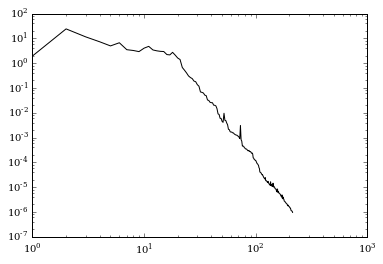

In [5]:
# Plot the max L-infinity errors that were found in building the "optimal" spline.
# Notice that the decay is polynomial (power is deg+1) and not exponential. 
# This is because the spline is only smooth to the degree of the polynomials used. 
# For this reason, it's good not to set the tolerance too high (e.g., numerical round-off).
plt.loglog(spline.errors, 'k-');

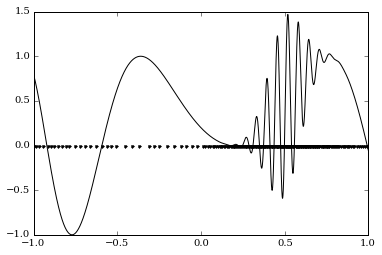

In [6]:
# The distribution of the "optimal" knots is not uniform. Generally speaking, the
# density of knots is highest aroun
plt.plot(spline.knots, np.zeros(len(spline.knots)), 'k.', x, f(x), 'k-');

In [7]:
# To evaluate the spline let's first create an array of new samples
import random
xx = np.sort([random.uniform(-0.5, 0.8) for ii in range(10000)])

# Then you can use "eval" to evaluate the spline
y1 = spline.eval(xx)

# ...or do the following:
y2 = spline(xx)

# These are equivalent -- their difference is an array of zeros
print np.all(np.abs(y1-y2) == 0.)

True


In [8]:
# You can write the relevant spline interpolant data to HDF5 format
spline.write('test1.h5')

In [9]:
# Next, let's pretend you've already saved the reduced-order spline data to file 
# and want to evaluate the interpolant given only a previously created data file. In this case, do the following:
s = romSpline.ReducedOrderSpline()
s.read('test1.h5')

In [10]:
# You can check that data was loaded by evaluating the spline at the xx samples
s.eval(xx)

array([ 0.63889144,  0.63952078,  0.63963112, ...,  0.96319792,
        0.9628776 ,  0.9628132 ])

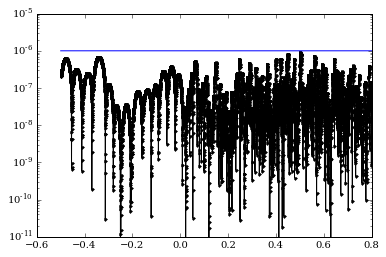

In [11]:
# Let's plot the difference bewteen the original function and the spline at xx.
# Also plotted in blue is the default tolerance (1e-6) used by the greedy algorithm
plt.semilogy(xx, np.abs(f(xx)-s.eval(xx)), 'k.-', xx, 1e-6*np.ones(xx.size), 'b-');
plt.ylim(1e-11, 1e-5);

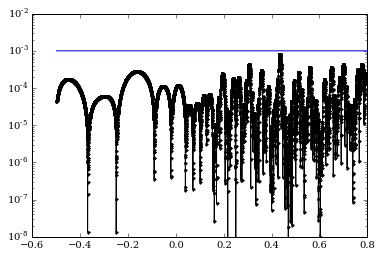

In [12]:
# Finally, we can rerun the greedy algorithm to make a spline with a different tolerance, for example.
# Using the same object "spline" (or you can create a new one), we run the "greedy" method
spline.greedy(x, f(x), tol=1e-3)

# ...and plot the spline errors at the xx samples like we did earlier
plt.semilogy(xx, np.abs(f(xx)-spline.eval(xx)), 'k.-', xx, 1e-3*np.ones(xx.size), 'b-');
plt.ylim(1e-8, 1e-2);

In [13]:
# And you can write this spline data to file, too
spline.write('test2.h5')

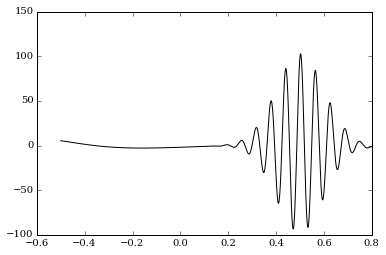

In [14]:
# One last comment. You can compute derivatives of the interpolated function, too. 
# For the first derivative just type:
spline.eval(xx, dx=1)

# and you can plot it...
plt.plot(xx, spline(xx, dx=1), 'k-');

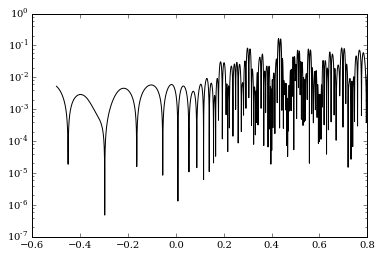

In [15]:
# and the error with the true derivative
def dfdx(x):
    return 10.*(x-0.2)*np.cos(5.*(x-0.2)**2) \
        + (100.*np.cos(100.*x)-(x-0.5)/0.01*np.sin(100*x)) * np.exp(-(x-0.5)**2/2./0.01)

plt.semilogy(xx, np.abs(dfdx(xx)-spline(xx, dx=1)), 'k-');